<a href="https://colab.research.google.com/github/ropholuo/ESE546-Intro-to-Deep-learning/blob/main/jinhuil_hw5_problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import torchvision as thv
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train_set = thv.datasets.MNIST('./', download=True, train=True, transform=thv.transforms.ToTensor())
val_set = thv.datasets.MNIST('./', download=True, train=False, transform=thv.transforms.ToTensor())
print(train_set.data.shape, len(train_set.targets))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

torch.Size([60000, 28, 28]) 60000


In [ ]:
num_class = np.unique(train_set.targets)
#num_count = {catagory: sum(y==catagory) for catagory in num_class}

# find the indexes of every samples in each class
sample_index = {}
for i, catagory in enumerate(num_class):
  index = [j for j, num in enumerate(train_set.targets) if num==catagory]
  sample_index[i] = index

# randomly choose samples in every class
x_train, x_val = [], []
train_idx = []
for catagory, idx in sample_index.items():
  class_trainidx = idx[:1000]
  train_idx += class_trainidx

np.random.shuffle(train_idx)
x_train = train_set.data[train_idx]
y_train = train_set.targets[train_idx]

x_train = x_train[:,::2,::2]

In [ ]:
x_train[x_train<=128] = 0
x_train[x_train>128] = 1
x_train = x_train.float()

In [ ]:
trainset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=100, shuffle=True)

In [ ]:
"""
Reference code from PyTorch: https://github.com/pytorch/examples/blob/master/vae/main.py
"""

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(196, 128)
        self.fc21 = nn.Linear(128, 8)
        self.fc22 = nn.Linear(128, 8)
        self.fc3 = nn.Linear(8, 128)
        self.fc4 = nn.Linear(128, 196)

    def encode(self, x):
        h1 = F.tanh(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        #return mu + eps*std
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.tanh(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 196))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [ ]:
def loss_function(recon_x, x, mu, logvar):
  BCE = F.binary_cross_entropy(recon_x, x.view(-1, 196), reduction='sum')

  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return BCE, KLD

In [ ]:
def train(epoch):
  # global bce_list, kld_list
    model.train()
    bce_list, kld_list = [], []
    for i in range(epoch):
      train_loss = 0
      for batch_idx, (data, _) in enumerate(train_loader):
          data = data.to(device)
          optimizer.zero_grad()
          recon_batch, mu, logvar = model(data)
          bce, kld = loss_function(recon_batch, data, mu, logvar)
          bce_list.append(bce)
          kld_list.append(kld)
          loss = bce+kld
          loss.backward()
          train_loss += loss.item()
          optimizer.step()
          if batch_idx % 10 == 0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  i, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader),
                  loss.item() / len(data)))

      print('====> Epoch: {} Average loss: {:.4f}'.format(
            i, train_loss / len(train_loader.dataset)))
    return bce_list, kld_list

In [ ]:
# global bce_list, kld_list
# bce_list, kld_list = [], []
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
bce_list, kld_list = train(epoch=50)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 0 [0/10000 (0%)]	Loss: 137.424355
Train Epoch: 0 [1000/10000 (10%)]	Loss: 122.389092
Train Epoch: 0 [2000/10000 (20%)]	Loss: 99.069932
Train Epoch: 0 [3000/10000 (30%)]	Loss: 78.076948
Train Epoch: 0 [4000/10000 (40%)]	Loss: 66.167217
Train Epoch: 0 [5000/10000 (50%)]	Loss: 63.129531
Train Epoch: 0 [6000/10000 (60%)]	Loss: 59.805781
Train Epoch: 0 [7000/10000 (70%)]	Loss: 57.125752
Train Epoch: 0 [8000/10000 (80%)]	Loss: 57.290322
Train Epoch: 0 [9000/10000 (90%)]	Loss: 55.877891
====> Epoch: 0 Average loss: 75.7930
Train Epoch: 1 [0/10000 (0%)]	Loss: 57.543115
Train Epoch: 1 [1000/10000 (10%)]	Loss: 56.267886
Train Epoch: 1 [2000/10000 (20%)]	Loss: 55.212324
Train Epoch: 1 [3000/10000 (30%)]	Loss: 55.363530
Train Epoch: 1 [4000/10000 (40%)]	Loss: 54.421050
Train Epoch: 1 [5000/10000 (50%)]	Loss: 55.035571
Train Epoch: 1 [6000/10000 (60%)]	Loss: 53.495874
Train Epoch: 1 [7000/10000 (70%)]	Loss: 50.193975
Train Epoch: 1 [8000/10000 (80%)]	Loss: 52.441270
Train Epoch: 1 [900

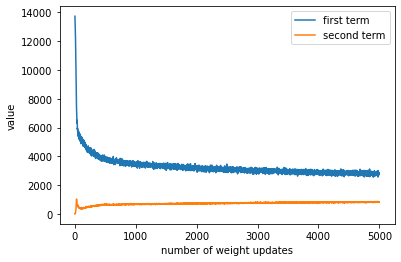

In [ ]:
plt.plot(bce_list, label='first term')
plt.plot(kld_list, label='second term')
plt.xlabel('number of weight updates')
plt.ylabel('value')
plt.legend()
plt.show()